In [67]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import random
np.random.seed(42)
random.seed(42)

# Données Utilisées
On commence par importer notre base de données : Le Crude Oil (West Texas Intermediate).

In [68]:
# Récupérer les données historiques pour WTI
start_date = datetime(1990, 1, 1)
end_date = datetime(2018, 1, 1)
wti_prices = pdr.get_data_fred('DCOILWTICO', start_date, end_date)
wti_prices=wti_prices.resample('M').mean()
print(wti_prices.head())

            DCOILWTICO
DATE                  
1990-01-31   22.863182
1990-02-28   22.113000
1990-03-31   20.387727
1990-04-30   18.425500
1990-05-31   18.199545


Les données sont collectée à partir de 1990 jusqu'à fin-2017 (prix mensuels). Cependant, avant de commencer on réalise un traitement afin d'éliminer les valeurs manquantes.

In [69]:
# On crée une nouvelle dataframe qui sera une copie de la première
df=pd.DataFrame()
df['Prix du Pétrole']=wti_prices.copy()
#On supprime le dernier prix qui est toujours vide
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336 entries, 1990-01-31 to 2017-12-31
Freq: M
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Prix du Pétrole  336 non-null    float64
dtypes: float64(1)
memory usage: 5.2 KB


Maintenant que notre base de données est traitée. On donne des informations sur nos données avec la fonction describe :

In [70]:
df.describe()

,Prix du Pétrole
count,336.000000
mean,46.795760
std,29.983759
min,11.347273
25%,20.795207
50%,34.363571
75%,69.492990
max,133.880000


Enfin on donne la représentation graphique de l'évolution du prix de pétrole.

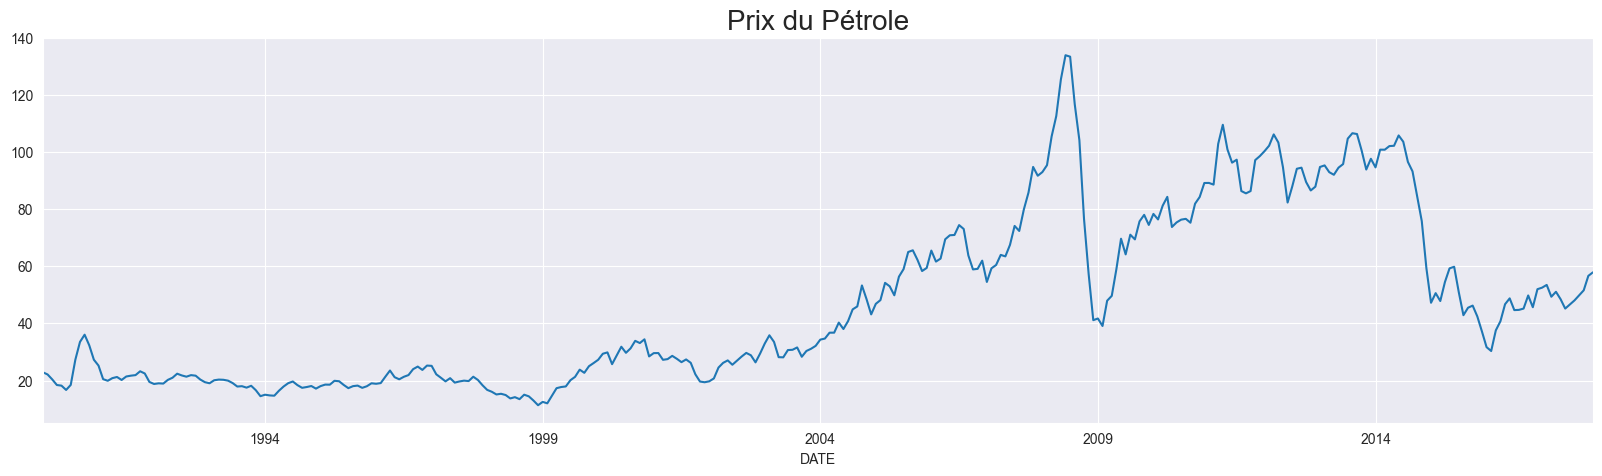

In [71]:
df['Prix du Pétrole'].plot(figsize=(20,5))
plt.title('Prix du Pétrole', size=20)
plt.show()

<Axes: ylabel='Density'>

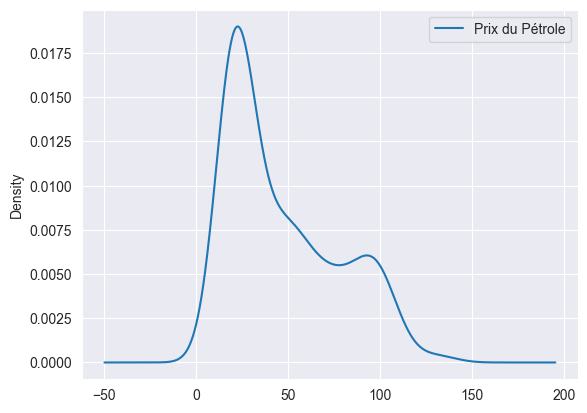

In [72]:
df.plot(kind='kde')

Le graphique si-dessus nous donne les prix qui apparaissent le plus. On remarque que généralement le prix du pétrole est entre 10 et 100 (en unité monétaire $\$), et que le prix des 25$\$ est le plus probable. 

# Élimination de la Saisonnalité
Dans cette partie on s'intéresse à la saisonnalité de nos données, et de son élimination dans le cas oû elle existe.

<Figure size 640x480 with 0 Axes>

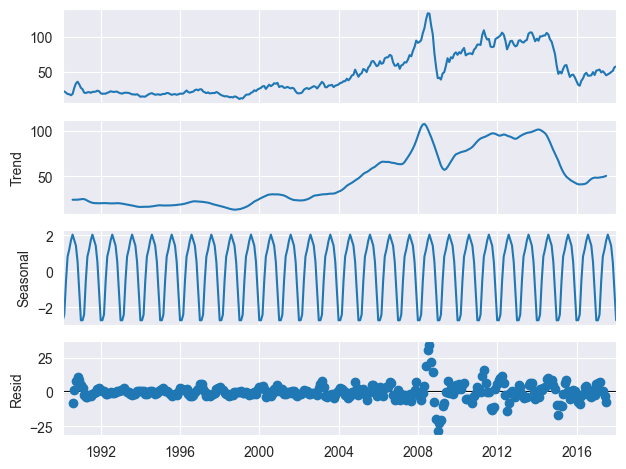

In [73]:
decomposition = seasonal_decompose(df, model='additive')
fig = plt.figure()
fig = decomposition.plot()
plt.show()

On remarque que la saisonnalité est négligeable, cependant on l'éliminera quand même.

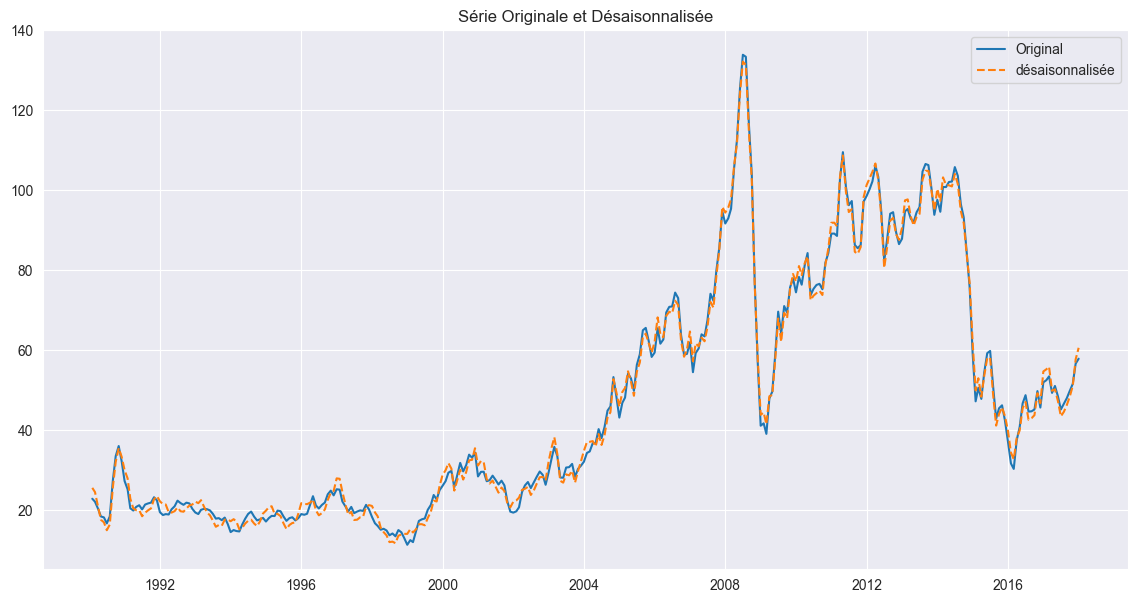

In [74]:
#Élimination de la composante de saisonnalité
seasonal=decomposition.seasonal
df['Prix du Pétrole-désaisonnalisée'] = df['Prix du Pétrole']-seasonal

# Tracer les séries originale et désaisonnalisée
plt.figure(figsize=(14, 7))
plt.plot(df['Prix du Pétrole'], label='Original')
plt.plot(df['Prix du Pétrole-désaisonnalisée'], label='désaisonnalisée', linestyle='--')
plt.legend()
plt.title('Série Originale et Désaisonnalisée')
plt.show()

# Phénomène de retour à la moyenne
On vérifie avec le test ADF (Augmented Dickey-Fuller) le phénomène de retour à la moyenne :

In [75]:
result = adfuller(df['Prix du Pétrole-désaisonnalisée'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("La série est stationnaire, indiquant un retour à la moyenne.")
else:
    print("La série n'est pas stationnaire, pas de retour à la moyenne.")

ADF Statistic: -1.6556518225091756
p-value: 0.45409452418979096
La série n'est pas stationnaire, pas de retour à la moyenne.


Ainsi comme la p-value est supérieur au seuil critique de 0.05, on peut conclure qu'il n'y a pas de retour à la moyenne.
# Modèle Schwartz-Brennan
On implemente le modèle de Schwartz-Brennan, on commence par implémenter une fonction de log-vraisemblance pour notre modèle,

In [76]:
# Fonction de log-vraisemblance pour le modèle de Brennan-Schwartz
def log_likelihood_bs(params, df):
    mu, sigma = params
    S = df['Prix du Pétrole-désaisonnalisée'].values
    n = len(S)
    dt = 1 / 12  # Monthly data
    
    likelihood = 0
    for i in range(1, n):
        variance = sigma**2 * S[i-1]**2 * dt
        mu_t = S[i-1] * (1 + mu * dt)
        likelihood += -0.5 * (np.log(2 * np.pi * variance) + ((S[i] - mu_t)**2 / variance))
    
    return -likelihood

On passe à l'estimation des paramètre en minimisant la fonction de log vraisemblance,

In [77]:
# Estimation des paramètres
initial_params = [0.1, 0.1]
bounds = [(0, None), (0, None)]
result = minimize(log_likelihood_bs, initial_params, args=(df,), bounds=bounds)
mu, sigma = result.x
print(f'Estimated parameters: mu = {mu}, sigma = {sigma}')

Estimated parameters: mu = 0.07557211298574375, sigma = 0.30085292796808283


Ensuite, on définit la fonction qui permet de simuler les prix,

In [78]:
# Simulation des prix futurs
def simulate_brennan_schwartz(mu, sigma, S0, periods,seed=42):
    np.random.seed(seed)
    dt = 1 / 12
    S = np.zeros(periods)
    S[0] = S0
    for t in range(1, periods):
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal())
    return S

Maintenant on passe à l'étape de simulation,

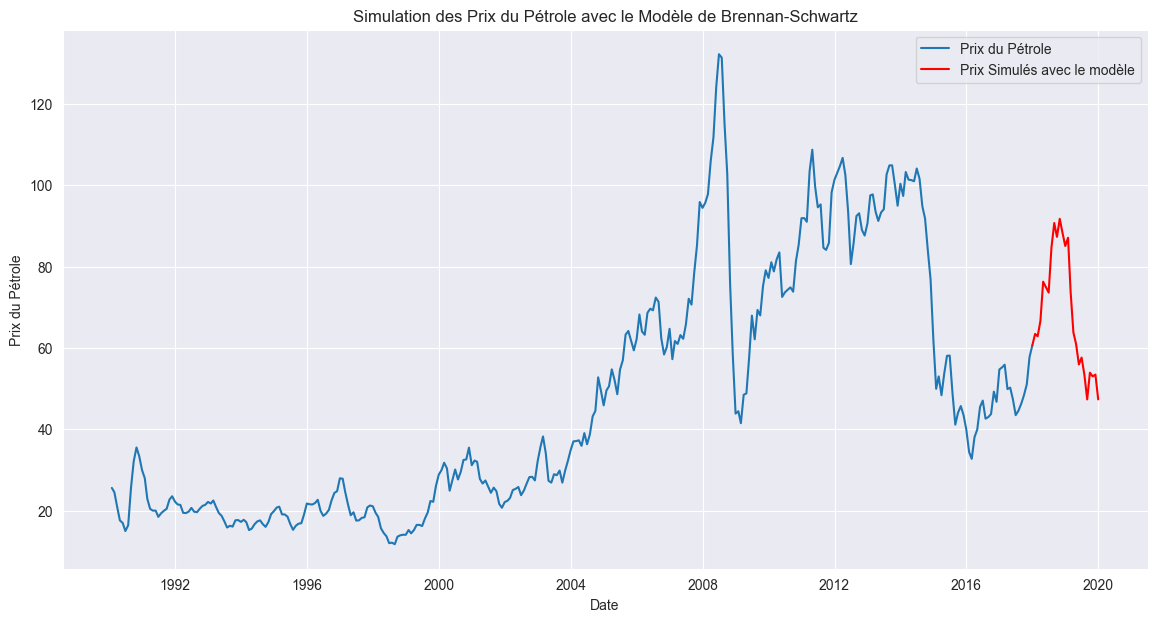

In [79]:
# Simuler les prix futurs pour 2018 et 2020
periods = 25  # 2 années de simulation 
simulated_prices_bs = simulate_brennan_schwartz(mu, sigma, df['Prix du Pétrole-désaisonnalisée'].iloc[-1], periods)

# Tracer les prix réels et simulés
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Prix du Pétrole-désaisonnalisée'], label='Prix du Pétrole')
plt.plot(pd.date_range(start=df.index[-1], periods=periods, freq='M'), simulated_prices_bs, label='Prix Simulés avec le modèle', color='red')
plt.xlabel('Date')
plt.ylabel('Prix du Pétrole')
plt.title('Simulation des Prix du Pétrole avec le Modèle de Brennan-Schwartz')
plt.legend()
plt.show()

Enfin, on réalise une comparaison avec les données réels

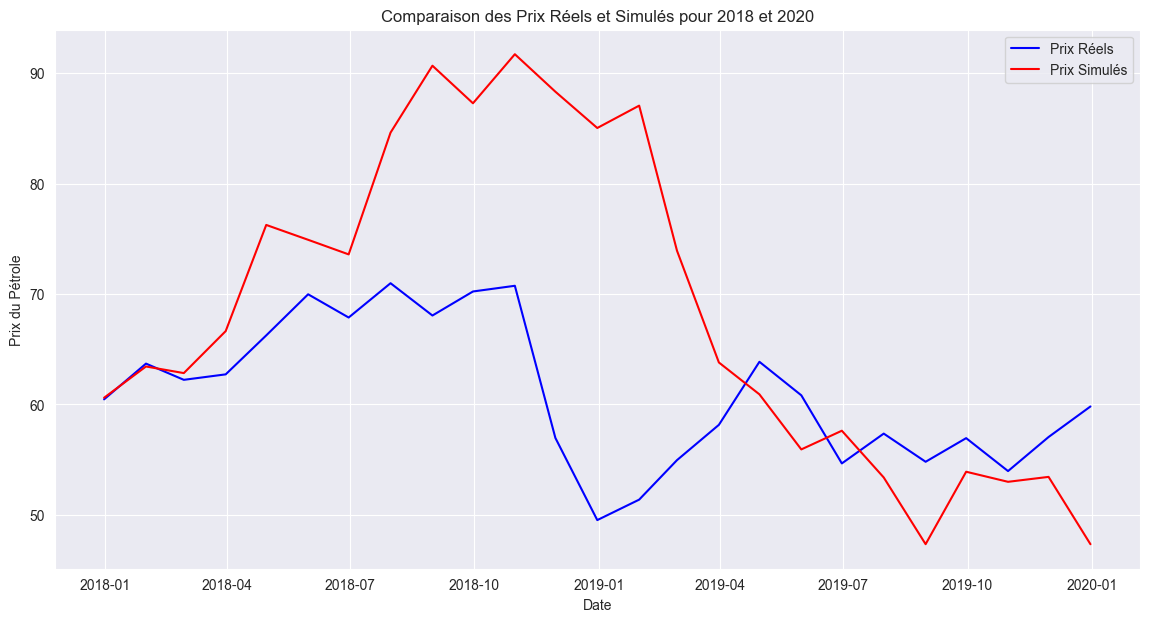

In [80]:
# Comparer avec les prix réels de 2018 et 2020
# On récupère les prix réels pour 2018 et 2020
end_date_2020 = datetime(2019, 12, 31)
real_prices = pdr.get_data_fred('DCOILWTICO', start=datetime(2017, 12, 29), end=end_date_2020)
real_prices = real_prices.resample('M').mean()
real_prices = real_prices.fillna(method='bfill')

# Tracer les prix réels et simulés
plt.figure(figsize=(14, 7))
plt.plot(real_prices.index, real_prices, label='Prix Réels', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=periods, freq='M'), simulated_prices_bs, label='Prix Simulés', color='red')
plt.xlabel('Date')
plt.ylabel('Prix du Pétrole')
plt.title('Comparaison des Prix Réels et Simulés pour 2018 et 2020')
plt.legend()
plt.show()


# Modèle de Clewlow
On suit la même logique

In [81]:
# Fonction de log-vraisemblance pour le modèle de Clewlow-Strickland
def log_likelihood_cs(params, df):
    alpha, sigma = params
    f = df['Prix du Pétrole-désaisonnalisée'].values
    n = len(f)
    dt = 1 / 12  # Monthly data
    
    likelihood = 0
    for i in range(1, n):
        gamma = sigma * np.exp(-alpha * (i * dt))
        mu = np.log(f[i-1]) + (sigma**2 / (2 * alpha)) * (1 - np.exp(-2 * alpha * dt))
        variance = (sigma**2 / (2 * alpha)) * (1 - np.exp(-2 * alpha * dt))
        likelihood += -0.5 * (np.log(2 * np.pi * variance) + ((np.log(f[i]) - mu)**2 / variance))
    
    return -likelihood

In [82]:
# Estimation des paramètres
initial_params = [0.1, 0.1]
bounds = [(0, None), (0, None)]
result = minimize(log_likelihood_cs, initial_params, args=(df,), bounds=bounds)
alpha, sigma = result.x
print(f'Estimated parameters: alpha = {alpha}, sigma = {sigma}')

Estimated parameters: alpha = 0.13314742225149998, sigma = 0.29916670153016967


In [83]:
# Simulation des prix futurs
def simulate_clewlow_strickland(alpha, sigma, f0, periods,seed=42):
    np.random.seed(seed)
    dt = 1 / 12
    f = np.zeros(periods)
    f[0] = f0
    for t in range(1, periods):
        gamma_t_T = sigma * np.exp(-alpha * (t * dt))
        integral_gamma2 = (sigma**2 / (2 * alpha)) * (1 - np.exp(-2 * alpha * t * dt))
        wiener_process = np.random.normal(0, 1)
        f[t] = f[0] * np.exp(-0.5 * integral_gamma2 + gamma_t_T * wiener_process)
    return f

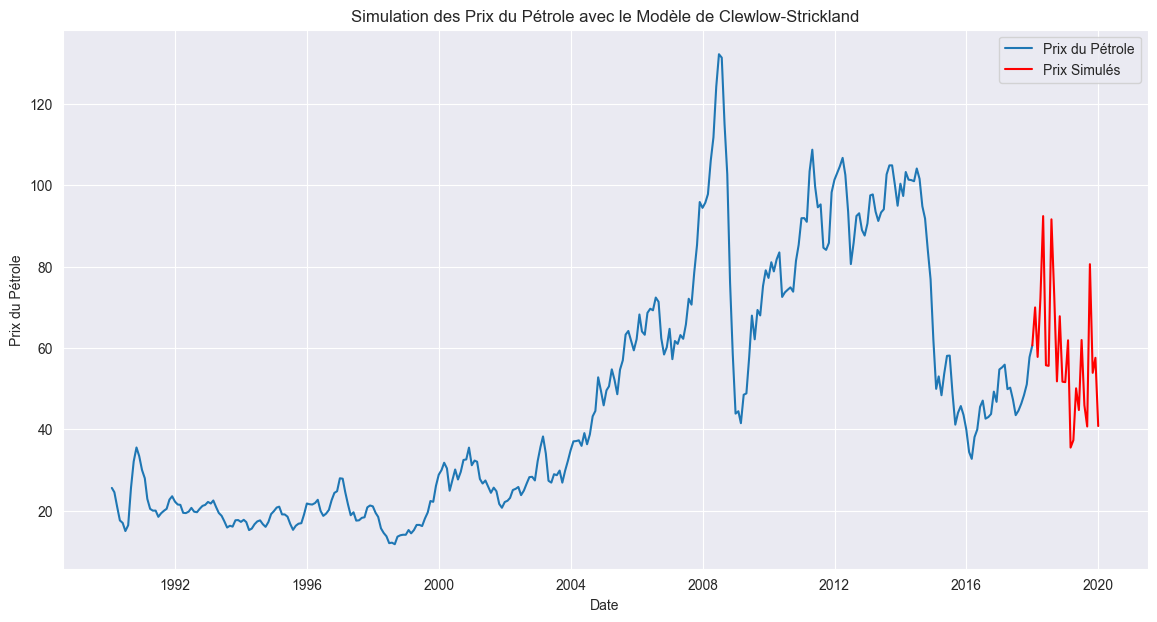

In [84]:
# Simuler les prix futurs pour 2018 et 2020
periods = 25  # 2 années
simulated_prices_cs = simulate_clewlow_strickland(alpha, sigma, df['Prix du Pétrole-désaisonnalisée'].iloc[-1], periods)

# Tracer les prix réels et simulés
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Prix du Pétrole-désaisonnalisée'], label='Prix du Pétrole')
plt.plot(pd.date_range(start=df.index[-1], periods=periods, freq='M'), simulated_prices_cs, label='Prix Simulés', color='red')
plt.xlabel('Date')
plt.ylabel('Prix du Pétrole')
plt.title('Simulation des Prix du Pétrole avec le Modèle de Clewlow-Strickland')
plt.legend()
plt.show()

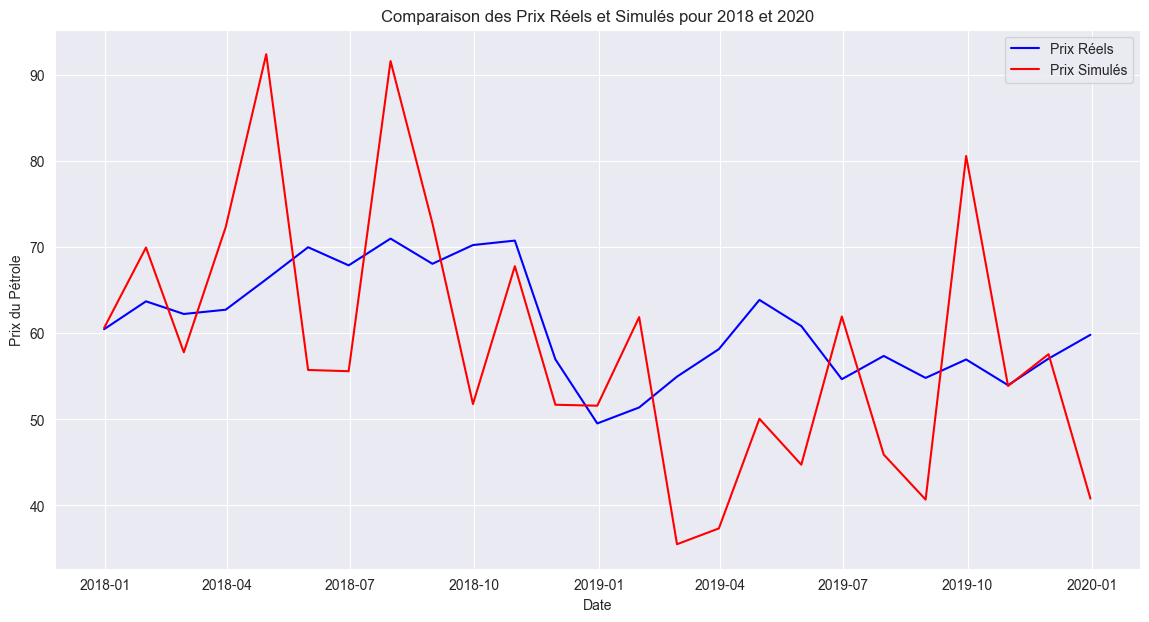

In [85]:
# Comparer avec les prix réels de 2018 et 2020
# On récupère les prix réels pour 2018 et 2020
end_date_2020 = datetime(2019, 12, 31)
real_prices = pdr.get_data_fred('DCOILWTICO', start=datetime(2017, 12, 29), end=end_date_2020)
real_prices = real_prices.resample('M').mean()
real_prices = real_prices.fillna(method='bfill')

# Tracer les prix réels et simulés
plt.figure(figsize=(14, 7))
plt.plot(real_prices.index, real_prices, label='Prix Réels', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=periods, freq='M'), simulated_prices_cs, label='Prix Simulés', color='red')
plt.xlabel('Date')
plt.ylabel('Prix du Pétrole')
plt.title('Comparaison des Prix Réels et Simulés pour 2018 et 2020')
plt.legend()
plt.show()


# Comparaison

Mean Squared Error (Brennan-Schwartz): 232.2102918561196
Mean Squared Error (Clewlow): 187.6698573028903


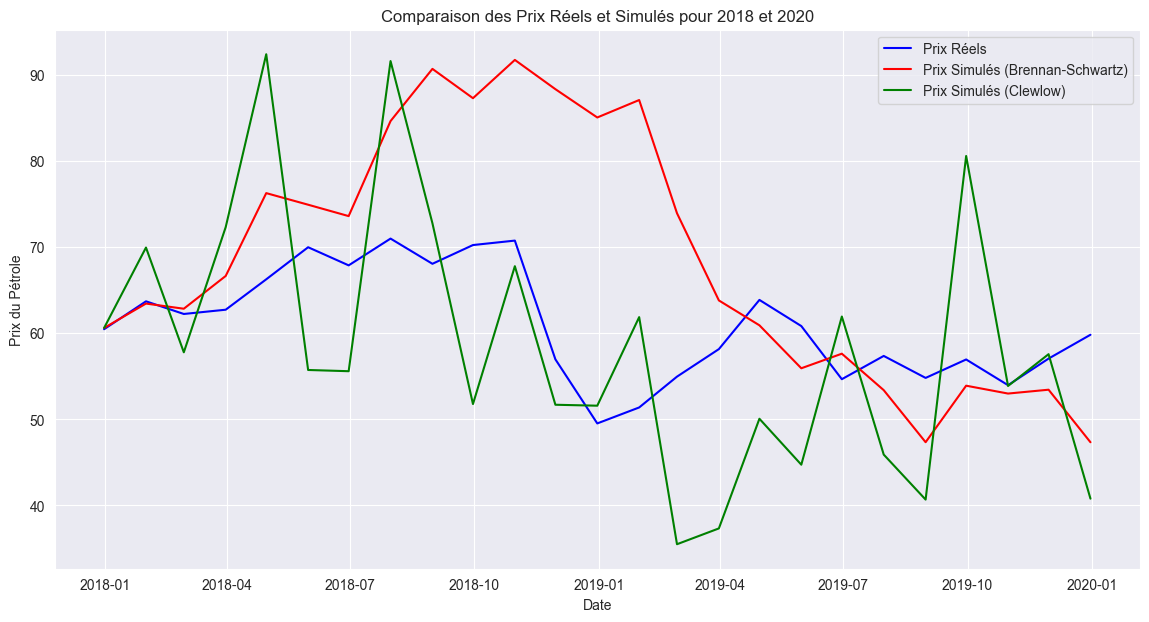

In [86]:
mse_bs = mean_squared_error(real_prices, simulated_prices_bs)
mse_cs = mean_squared_error(real_prices, simulated_prices_cs)

print(f'Mean Squared Error (Brennan-Schwartz): {mse_bs}')
print(f'Mean Squared Error (Clewlow): {mse_cs}')

### Tracer les prix réels et simulés pour les deux modèles

plt.figure(figsize=(14, 7))
plt.plot(real_prices.index, real_prices, label='Prix Réels', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=periods, freq='M'), simulated_prices_bs, label='Prix Simulés (Brennan-Schwartz)', color='red')
plt.plot(pd.date_range(start=df.index[-1], periods=periods, freq='M'), simulated_prices_cs, label='Prix Simulés (Clewlow)', color='green')
plt.xlabel('Date')
plt.ylabel('Prix du Pétrole')
plt.title('Comparaison des Prix Réels et Simulés pour 2018 et 2020')
plt.legend()
plt.show()

Prix de l'option européenne: 0.00


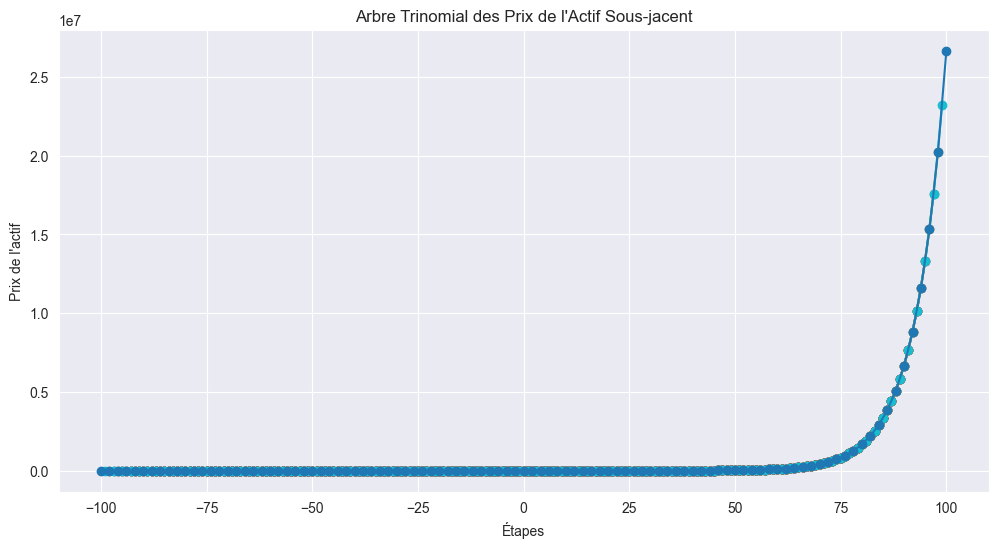

Prix de l'option Swing: 0.00
Payoff du contrat Swap: -40.20


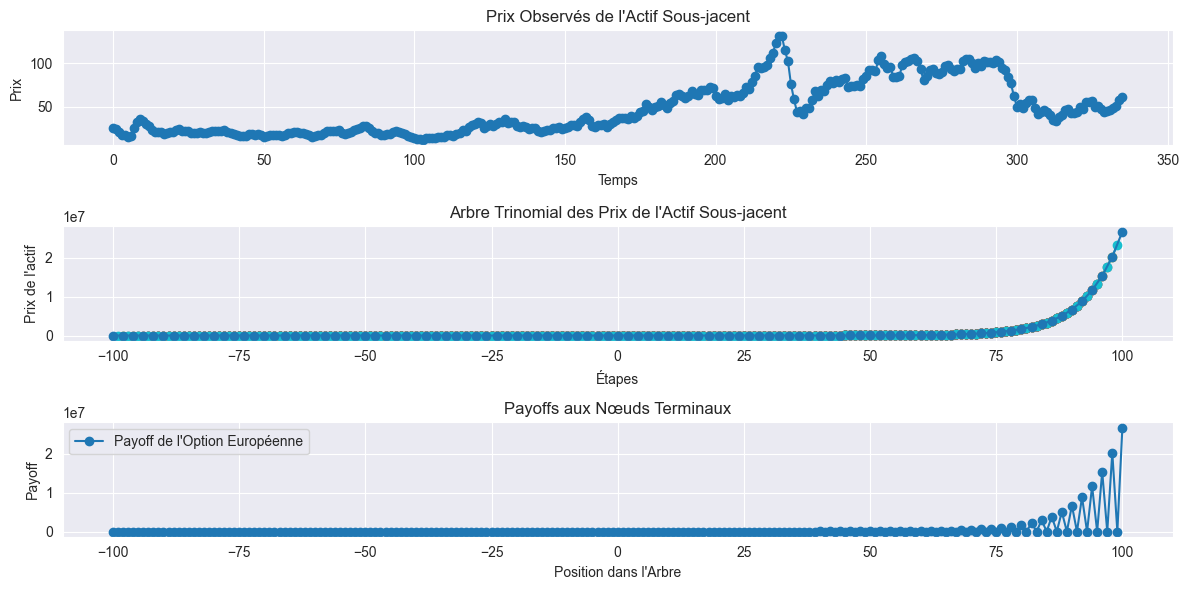

Prix de l'option Swing: 0.00
Payoff du contrat Swap: -40.20


In [87]:
# Assuming 'Prix du Pétrole-désaisonnalisée' is already present in the df
prices_observed = df['Prix du Pétrole-désaisonnalisée'].values

# Parameters for the model
S0 = prices_observed[0]  # Initial underlying asset price from data
K = 30   # Strike price
T = 12*2   # Maturity (in years)
r = 0.05  # Risk-free interest rate
sigma = 0.2  # Volatility
N = 100   # Number of time steps
window_size = 10  # Define window_size

# Trinomial model parameters
dt = T / N  # Time step
u = np.exp(sigma * np.sqrt(2 * dt))  # Up factor
d = 1 / u  # Down factor
m = 1  # Middle factor (price remains constant)

# Transition probabilities
pu = ((np.exp(r * dt / 2) - np.exp(-sigma * np.sqrt(dt / 2))) /
      (np.exp(sigma * np.sqrt(dt / 2)) - np.exp(-sigma * np.sqrt(dt / 2))))**2
pd = ((np.exp(sigma * np.sqrt(dt / 2)) - np.exp(r * dt / 2)) /
      (np.exp(sigma * np.sqrt(dt / 2)) - np.exp(-sigma * np.sqrt(dt / 2))))**2
pm = 1 - pu - pd  # Stagnation probability

# Generate price tree
def generate_tree(S0, u, d, m, N):
    tree = np.zeros((2 * N + 1, N + 1))
    tree[N, 0] = S0
    for j in range(1, N + 1):
        for i in range(-j, j + 1, 2):
            tree[N + i, j] = S0 * (u ** max(i, 0)) * (d ** max(-i, 0))
    return tree

# Payoff calculation at terminal nodes for European option
def payoff(tree, K, N):
    payoff = np.maximum(0, tree[:, -1] - K)
    return payoff.reshape((2 * N + 1, 1))  # Reshape to 2D array

# Price option by backward induction
def price_option(tree, payoff, pu, pm, pd, r, dt):
    N = len(payoff[0]) - 1  # Adjust N based on the dimensions of payoff
    for j in range(N - 1, -1, -1):
        for i in range(-j, j + 1, 2):
            payoff[N + i, j] = (pu * payoff[N + i + 1, j + 1] +
                                pm * payoff[N + i, j + 1] +
                                pd * payoff[N + i - 1, j + 1]) * np.exp(-r * dt)
    return payoff[N, 0]

# Generate price tree
tree = generate_tree(S0, u, d, m, N)

# Calculate payoffs at terminal nodes
payoff_values = payoff(tree, K, N)

# Calculate option price
option_price = price_option(tree, payoff_values, pu, pm, pd, r, dt)
print(f"Prix de l'option européenne: {option_price:.2f}")

# Visualize price tree
plt.figure(figsize=(12, 6))
for j in range(N + 1):
    plt.plot(range(-j, j + 1, 2), tree[N-j:N+j+1:2, j], marker='o')
plt.title("Arbre Trinomial des Prix de l'Actif Sous-jacent")
plt.xlabel('Étapes')
plt.ylabel("Prix de l'actif")
plt.grid(True)
plt.show()

# Swing option pricing function
def swing_option_trinomial(prices, strike, maturity, window_size, N, u, d, m, pu, pm, pd, r, dt):
    tree = generate_tree(prices[0], u, d, m, N)
    payoff = np.zeros((2 * N + 1, N + 1))
    
    for j in range(N, -1, -1):
        for i in range(-j, j + 1, 2):
            if j == N:
                payoff[N + i, j] = max(0, tree[N + i, j] - strike)
            else:
                exercise = max(0, tree[N + i, j] - strike)
                hold = (pu * payoff[N + i + 1, j + 1] +
                        pm * payoff[N + i, j + 1] +
                        pd * payoff[N + i - 1, j + 1]) * np.exp(-r * dt)
                payoff[N + i, j] = max(exercise, hold)
    
    return payoff[N, 0]

# Calculate swing option price
strike_price = 90  # Define strike_price
swing_price = swing_option_trinomial(prices_observed, strike_price, T, window_size, N, u, d, m, pu, pm, pd, r, dt)
print(f"Prix de l'option Swing: {swing_price:.2f}")

# Swap contract pricing function
def swap_contract_trinomial(prices, fixed_rate, maturity, N, u, d, m, pu, pm, pd, r, dt):
    tree = generate_tree(prices[0], u, d, m, N)
    floating_payments = np.zeros((2 * N + 1, N + 1))
    fixed_payments = np.full((2 * N + 1, N + 1), fixed_rate)
    
    for j in range(N, -1, -1):
        for i in range(-j, j + 1, 2):
            if j == N:
                floating_payments[N + i, j] = tree[N + i, j]
            else:
                floating_payments[N + i, j] = (pu * floating_payments[N + i + 1, j + 1] +
                                               pm * floating_payments[N + i, j + 1] +
                                               pd * floating_payments[N + i - 1, j + 1]) * np.exp(-r * dt)
    
    swap_payoff = np.sum(floating_payments[:, :maturity] - fixed_payments[:, :maturity])
    return swap_payoff

# Calculate swap contract payoff
fixed_rate = 0.04  # Define fixed_rate
maturity = 5  # Define maturity
swap_price = swap_contract_trinomial(prices_observed, fixed_rate, maturity, N, u, d, m, pu, pm, pd, r, dt)
print(f"Payoff du contrat Swap: {swap_price:.2f}")

# Visualizations
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(prices_observed, 'o-')
plt.title("Prix Observés de l'Actif Sous-jacent")
plt.xlabel('Temps')
plt.ylabel('Prix')

plt.subplot(3, 1, 2)
for j in range(N + 1):
    plt.plot(range(-j, j + 1, 2), tree[N-j:N+j+1:2, j], marker='o')
plt.title("Arbre Trinomial des Prix de l'Actif Sous-jacent")
plt.xlabel('Étapes')
plt.ylabel("Prix de l'actif")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(range(-N, N+1), payoff_values, 'o-', label="Payoff de l'Option Européenne")
plt.title("Payoffs aux Nœuds Terminaux")
plt.xlabel('Position dans l\'Arbre')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final results display
print(f"Prix de l'option Swing: {swing_price:.2f}")
print(f"Payoff du contrat Swap: {swap_price:.2f}")


In [88]:
def swing_option_trinomial(prices, strike, maturity, window_size, N, u, d, m, pu, pm, pd, r, dt):
  """
  This function performs Monte Carlo simulation for Swing Option pricing using a trinomial tree.

  Args:
      prices: List of initial asset prices for simulations.
      strike: Strike price of the Swing Option.
      maturity: Maturity of the Swing Option (number of time steps).
      window_size: Window size for Swing Option exercise (number of time steps).
      N: Number of time steps in the trinomial tree.
      u, d, m, pu, pm, pd: Trinomial model parameters.
      r: Risk-free interest rate.
      dt: Time step.

  Returns:
      List of Swing Option prices for each simulation.
  """
  swing_prices = []
  for price in prices:
    tree = generate_tree(price, u, d, m, N)
    payoff = np.zeros((2 * N + 1, N + 1))

    for j in range(N, -1, -1):
      for i in range(-j, j + 1, 2):
        if j == N:
          payoff[N + i, j] = max(0, tree[N + i, j] - strike)
        else:
          exercise = max(0, tree[N + i, j] - strike)
          hold = (pu * payoff[N + i + 1, j + 1] +
                  pm * payoff[N + i, j + 1] +
                  pd * payoff[N + i - 1, j + 1]) * np.exp(-r * dt)
          payoff[N + i, j] = max(exercise, hold)

      # Consider only payoffs within the window for Swing Option exercise
      swing_value = np.max(payoff[:-(N - maturity), 0])
      swing_prices.append(swing_value * np.exp(-r * maturity * dt))  # Discount to present value

  return swing_prices


In [89]:
def swap_contract_trinomial(prices, fixed_rate, maturity, N, u, d, m, pu, pm, pd, r, dt):
  """
  This function calculates the Swap payoff using a trinomial tree.

  Args:
      prices: List of initial asset prices for simulations.
      fixed_rate: Fixed interest rate for the Swap.
      maturity: Maturity of the Swap (number of time steps).
      N: Number of time steps in the trinomial tree.
      u, d, m, pu, pm, pd: Trinomial model parameters.
      r: Risk-free interest rate.
      dt: Time step.

  Returns:
      List of Swap payoffs for each simulation.
  """
  swap_payoffs = []
  for price in prices:
    tree = generate_tree(price, u, d, m, N)
    floating_payments = np.zeros((2 * N + 1, N + 1))
    fixed_payments = np.full((2 * N + 1, N + 1), fixed_rate)

    for j in range(N, -1, -1):
      for i in range(-j, j + 1, 2):
        if j == N:
          floating_payments[N + i, j] = tree[N + i, j]
        else:
          floating_payments[N + i, j] = (pu * floating_payments[N + i + 1, j + 1] +
                                         pm * floating_payments[N + i, j + 1] +
                                         pd * floating_payments[N + i - 1, j + 1]) * np.exp(-r * dt)

    swap_payoff = np.sum(floating_payments[:, :maturity] - fixed_payments[:, :maturity])
    swap_payoffs.append(swap_payoff)

  return swap_payoffs


In [90]:
# Example usage (assuming you have a list of initial asset prices)
num_simulations = 1000  # Number of simulations
swing_prices = swing_option_trinomial(prices_observed, strike_price, maturity, window_size, N, u, d, m, pu, pm, pd, r, dt)
swap_payoffs = swap_contract_trinomial(prices_observed, fixed_rate, maturity, N, u, d, m, pu, pm, pd, r, dt)

# Analyze and display results
average_swing_price = np.mean(swing_prices)
average_swap_payoff = np.mean(swap_payoffs)

print(f"Average Swing Option Price (Monte Carlo): {average_swing_price:.2f}")
print(f"Average Swap Payoff (Monte Carlo): {average_swap_payoff:.2f}")

# Optional: Analyze distribution of swing prices and swap payoffs using histograms or other techniques


Average Swing Option Price (Monte Carlo): 0.02
Average Swap Payoff (Monte Carlo): -40.20
